In [1]:
! pip3 install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
! pip install -q missingno
! pip install -q folium
! pip install -q pandas==1.4.0
! pip install -q scikit-learn==1.3.2 --upgrade
! pip install -q catboost
! pip install -q xgboost



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastparquet 2024.2.0 requires pandas>=1.5.0, but you have pandas 1.4.0 which is incompatible.

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


**Group Sigma**

- Prajwal Luitel (C0927658)
- Rajan Ghimire (C0924991)
- Shishir Mishra (C0927250)
- Aarjeyan Shrestha (C0927422)
- Sudip Chaudhary (C0922310)

In [2]:
# importing all libraries 

import pandas
import numpy as np 
import pandas as pd
import seaborn as sns
import missingno as msno
import plotly.express as px
import matplotlib.pyplot as plt


from plotly.offline import *

init_notebook_mode(connected = True)
%matplotlib inline

import folium
from scipy.stats import chi2_contingency
from folium.plugins import MarkerCluster


from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from xgboost import XGBClassifier



from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score


from sklearn.exceptions import ConvergenceWarning
ConvergenceWarning('ignore')



sklearn.exceptions.ConvergenceWarning('ignore')

In [3]:
# import plotly.io as pio
# pio.renderers.default = "notebook+pdf"

## Data Exploration

In [4]:
# Read the Dataframe
df = pd.read_csv("/kaggle/input/is-the-traffic-collision-fatal/Train.csv")

# view the top 3 dataframe
df.head(3)

,INDEX_,ACCNUM,YEAR,DATE,TIME,STREET1,STREET2,OFFSET,ROAD_CLASS,DISTRICT,...,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,HOOD_158,NEIGHBOURHOOD_158,HOOD_140,NEIGHBOURHOOD_140,DIVISION,ObjectId
0,3387730,892658.0,2006,2006/03/11 05:00:00+00,852,BLOOR ST W,DUNDAS ST W,NaN,Major Arterial,Toronto and East York,...,Yes,NaN,NaN,NaN,88,High Park North,88,High Park North (88),D11,1
1,3387731,892658.0,2006,2006/03/11 05:00:00+00,852,BLOOR ST W,DUNDAS ST W,NaN,Major Arterial,Toronto and East York,...,Yes,NaN,NaN,NaN,88,High Park North,88,High Park North (88),D11,2
2,3388101,892810.0,2006,2006/03/11 05:00:00+00,915,MORNINGSIDE AVE,SHEPPARD AVE E,NaN,Major Arterial,Scarborough,...,Yes,Yes,NaN,NaN,146,Malvern East,132,Malvern (132),D42,3


**Checking Redundant/duplicate rows in the dataframe:**

In [5]:
unique_id = df['INDEX_'].nunique()

total_rows = df.shape[0]

print(f"Total Duplicate Rows: {total_rows-unique_id}")

#Removing the duplicate rows.
df = df.sort_values("INDEX_", ascending=False).drop_duplicates(subset='INDEX_', keep="first")

print(f"After Dropping duplicates, Number of row Before : {total_rows}, After  : {df.shape[0]}")

Total Duplicate Rows: 0
After Dropping duplicates, Number of row Before : 15000, After  : 15000


**Removing Noise Features and Features that may cause Data Leak**

- `FATAL_NO` is assigned only to accidents that resulted in fatalities. It would be inappropriate because it would introduce data leakage.
- `INDEX_`, `ACCNUM`, `ObjectId` are unique identifiers.

In [6]:
df.drop(["INDEX_", "ObjectId", "ACCNUM", "FATAL_NO"], axis= 1 , inplace= True)


**Getting all Categorical and Continious dtypes**

In [7]:
# Step 1: Get all the object
cat_columns = df.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns: {cat_columns}")

# Step 2: Get all numeric data types
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.to_list()
print(f"Numerical columns: {numerical_cols}")


print(f"Total Columns in datase: {df.shape[1]}")
print(f"Identified data type: {len(cat_columns) + len(numerical_cols)}")

assert df.shape[1] == len(cat_columns) + len(numerical_cols) , "Some columns not indentified."

Categorical columns: ['DATE', 'STREET1', 'STREET2', 'OFFSET', 'ROAD_CLASS', 'DISTRICT', 'LOCCOORD', 'ACCLOC', 'TRAFFCTL', 'VISIBILITY', 'LIGHT', 'RDSFCOND', 'ACCLASS', 'IMPACTYPE', 'INVTYPE', 'INVAGE', 'INJURY', 'INITDIR', 'VEHTYPE', 'MANOEUVER', 'DRIVACT', 'DRIVCOND', 'PEDTYPE', 'PEDACT', 'PEDCOND', 'CYCLISTYPE', 'CYCACT', 'CYCCOND', 'PEDESTRIAN', 'CYCLIST', 'AUTOMOBILE', 'MOTORCYCLE', 'TRUCK', 'TRSN_CITY_VEH', 'EMERG_VEH', 'PASSENGER', 'SPEEDING', 'AG_DRIV', 'REDLIGHT', 'ALCOHOL', 'DISABILITY', 'HOOD_158', 'NEIGHBOURHOOD_158', 'HOOD_140', 'NEIGHBOURHOOD_140', 'DIVISION']
Numerical columns: ['YEAR', 'TIME', 'WARDNUM', 'LATITUDE', 'LONGITUDE']
Total Columns in datase: 51
Identified data type: 51


**Some numberic columns might also be categorical. So, lets check sanity of numerical columns**

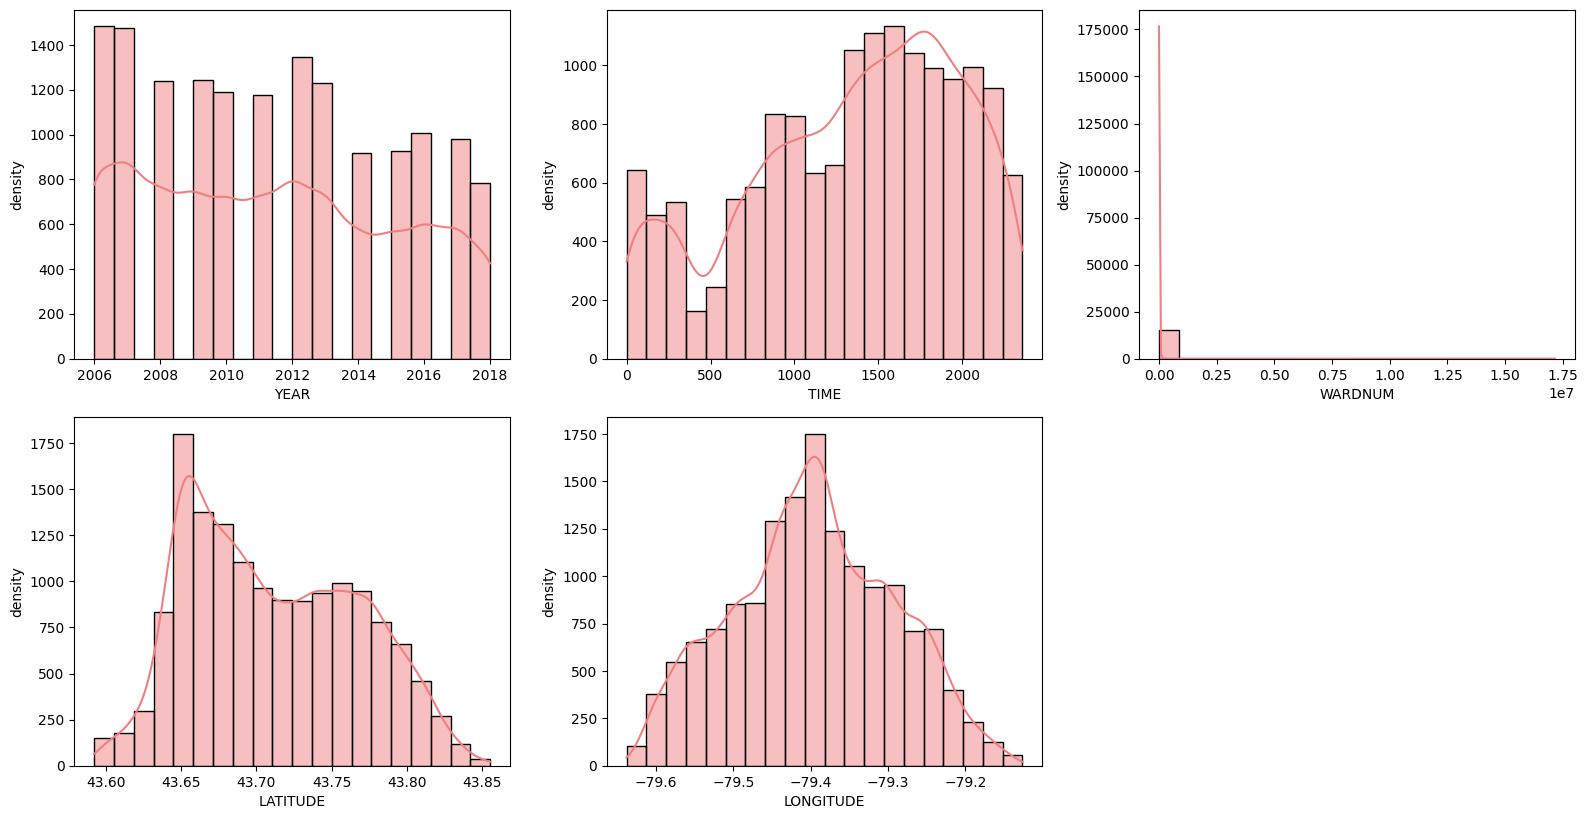

In [8]:
 
numerical_df = df[numerical_cols]

plt.figure(figsize=(16, 16))
for feature in numerical_df.columns.to_list():
    plt.subplot(4, 3, numerical_df.columns.to_list().index(feature) + 1)
    sns.histplot(data=numerical_df[feature], bins=20, kde=True, color="lightcoral")
    plt.ylabel("density")
plt.tight_layout()
plt.show()

### Handeing missing values

<Axes: >

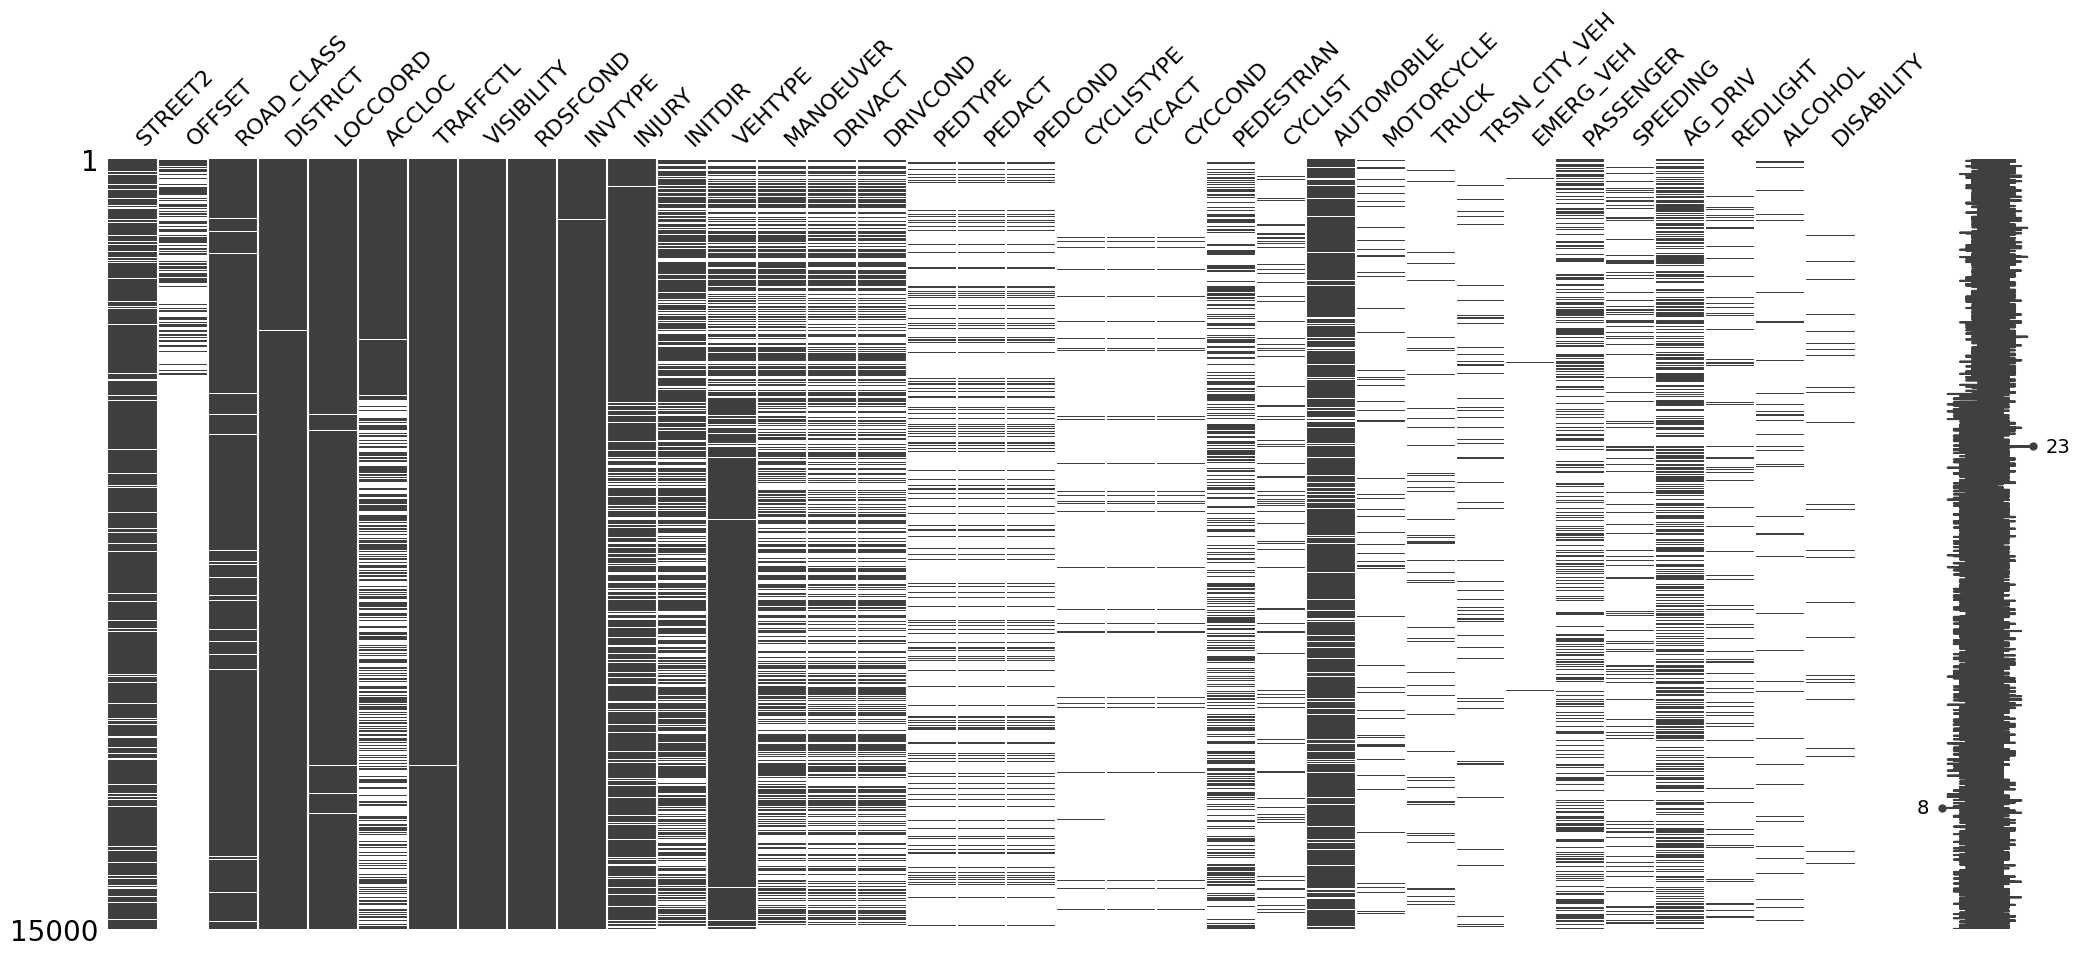

In [9]:
# get all columns with missing values.

col_mis_val = df.columns[df.isnull().sum() > 0]
col_mis_val = col_mis_val.to_list()

# visualize missing values with missingno.

msno.matrix(df[col_mis_val])

**Data Completeness per column**

<Axes: >

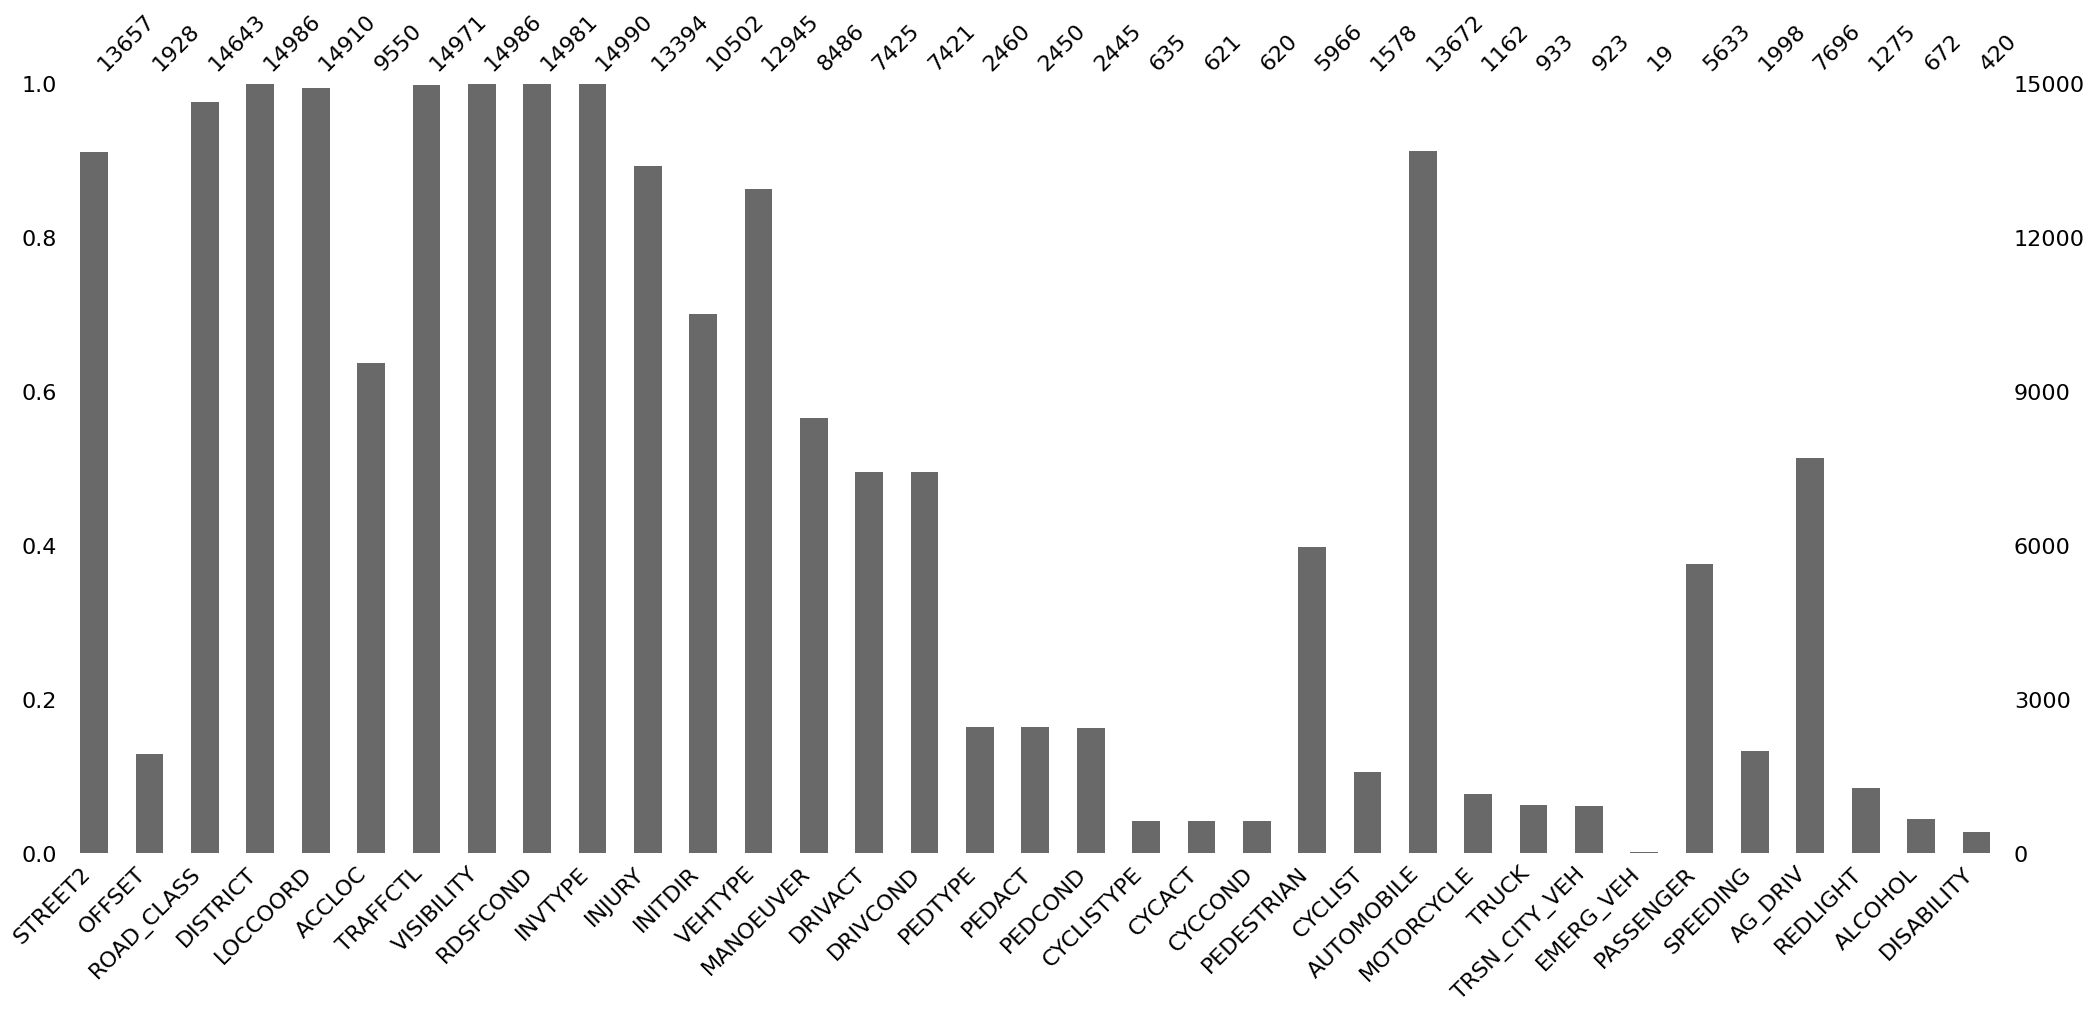

In [10]:
msno.bar(df[col_mis_val])

**Get all columns whose missing values are greater than 50%**

In [11]:

to_be_dropeed = df[col_mis_val].columns[df[col_mis_val].isna().mean() * 100 > 50]
print(f"More than 50% missing values:\n{list(to_be_dropeed)}")

More than 50% missing values:
['OFFSET', 'DRIVACT', 'DRIVCOND', 'PEDTYPE', 'PEDACT', 'PEDCOND', 'CYCLISTYPE', 'CYCACT', 'CYCCOND', 'PEDESTRIAN', 'CYCLIST', 'MOTORCYCLE', 'TRUCK', 'TRSN_CITY_VEH', 'EMERG_VEH', 'PASSENGER', 'SPEEDING', 'REDLIGHT', 'ALCOHOL', 'DISABILITY']


### Missing at Random check

In [12]:
# iterate through each of the missing feature to see thier value counts: 
for feature in to_be_dropeed:
    print("--"*10,feature,"--"*10)
    print(df[str(feature)].value_counts())

-------------------- OFFSET --------------------
5 m South of     29
10 m North of    29
10 m West of     28
10 m South of    24
100 m East of    24
                 ..
51 m East of      1
84 m North of     1
13 m North of     1
245 m East of     1
38 m North of     1
Name: OFFSET, Length: 339, dtype: int64
-------------------- DRIVACT --------------------
Driving Properly                3421
Failed to Yield Right of Way    1225
Lost control                     746
Improper Turn                    458
Other                            406
Disobeyed Traffic Control        391
Following too Close              226
Exceeding Speed Limit            188
Speed too Fast For Condition     161
Improper Lane Change             105
Improper Passing                  86
Wrong Way on One Way Road          9
Speed too Slow                     3
Name: DRIVACT, dtype: int64
-------------------- DRIVCOND --------------------
Normal                                4795
Inattentive                           

In [13]:
# Select the top features that we think are important with MAR. 
MAR_ = ['PEDESTRIAN', 'CYCLIST', 'MOTORCYCLE', 'TRUCK', 'TRSN_CITY_VEH', 'EMERG_VEH', 'PASSENGER', 'SPEEDING', 'REDLIGHT', 'ALCOHOL', 'DISABILITY', "AUTOMOBILE", "AG_DRIV"]
df[MAR_] = df[MAR_].fillna("No")

In [14]:

to_be_dropeed = df[col_mis_val].columns[df[col_mis_val].isna().mean() * 100 > 50]
print(f"More than 50% missing values:\n{list(to_be_dropeed)}")
df.drop(to_be_dropeed, axis=1, inplace=True)  

More than 50% missing values:
['OFFSET', 'DRIVACT', 'DRIVCOND', 'PEDTYPE', 'PEDACT', 'PEDCOND', 'CYCLISTYPE', 'CYCACT', 'CYCCOND']


### Converting Street 1 and 2 to intersection.

In [15]:
def create_intersection(row):
    if pd.isnull(row['STREET2']):
        return row['STREET1']
    else:
        return f"{row['STREET1']} / {row['STREET2']}"

df['INTERSECTION'] = df.apply(create_intersection, axis=1)

# We can drop the street 1 and 2 features now 
df.drop(['STREET1', 'STREET2'], axis=1, inplace=True)


**Are all missing values from categorical columns?**

In [16]:
# Again lets have a look at columns with missing values
col_mis_val = df.columns[df.isnull().sum() > 0].to_list()

# check if all missing values are now from categorical datatypes.
set(col_mis_val).issubset(set(cat_columns))

True

In [17]:
# Mode imputation for columns with moderate to few categories
for col in col_mis_val:
    mode_value = df[col].mode()[0]
    print(f"Mode of column : {col} is : {mode_value} ")
    df[col] = df[col].fillna(mode_value)

Mode of column : ROAD_CLASS is : Major Arterial 
Mode of column : DISTRICT is : Toronto and East York 
Mode of column : LOCCOORD is : Intersection 
Mode of column : ACCLOC is : At Intersection 
Mode of column : TRAFFCTL is : No Control 
Mode of column : VISIBILITY is : Clear 
Mode of column : RDSFCOND is : Dry 
Mode of column : INVTYPE is : Driver 
Mode of column : INJURY is : None 
Mode of column : INITDIR is : East 
Mode of column : VEHTYPE is : Automobile, Station Wagon 
Mode of column : MANOEUVER is : Going Ahead 


## EDA

In [18]:
df['HOUR'] = df['TIME'].astype(str).str.zfill(4).str[:2].astype(int)

df.drop("TIME", axis= 1 , inplace= True)

# Ensure 'DATE' is in datetime format
df['DATE'] = pd.to_datetime(df['DATE'])
df['YEAR'] = df['DATE'].dt.year
df['MONTH'] = df['DATE'].dt.month

**Accidents By Month**

In [19]:
# define month name 
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Group by YEAR + MONTH + COunt 
monthly_accidents = df.groupby(['YEAR', 'MONTH']).size().reset_index(name='counts')
# PIVOT
pivot_df = monthly_accidents.pivot(index='MONTH', columns='YEAR', values='counts').fillna(0)


fig = px.line(pivot_df, x=pivot_df.index, y=pivot_df.columns,
              labels={'value':'Number of Accidents', 'index':'Month'},
              title='Monthly accidents for each year', 
              template='plotly_dark')

fig.update_xaxes(tickvals=list(range(1, 13)), ticktext=month_names)
fig.update_layout(xaxis_title='Month',
                yaxis_title='Number of Accidents',
                legend_title="Different Years", height = 800)

fig.show()

**Accident distribution each year.**

In [20]:
# Group by year and ACLASSS
acp = df.groupby('YEAR')['ACCLASS'].value_counts().unstack()

# define bar plot
fig = px.bar(acp.reset_index(), x='YEAR', y=acp.columns,
             title="Proportion of ACCLASS Categories by Year", 
             template='plotly_dark'
             )

fig.update_layout(barmode='group', xaxis_title='Year', yaxis_title='Proportion',
                  legend_title="ACCLASS Categories", height = 800)


fig.show()

**Accident distribution each month.**

In [21]:
# Group by month and ACCLASS
# then count occurences
mcd = df.groupby(['MONTH', 'ACCLASS']).size().reset_index(name='counts')

# pivot for easy plot
pivot_df = mcd.pivot(index='MONTH', columns='ACCLASS', values='counts').fillna(0)

# define line plot
fig = px.line(pivot_df, x=pivot_df.index, y=pivot_df.columns, title='ACCLASS Distribution by Month',
              labels={'value':'Number of Cases', 'variable':'ACCLASS', 'MONTH':'Month'},
              template='plotly_dark')

# add month name for x tick 
fig.update_xaxes(tickvals=list(range(1, 13)), ticktext=month_names)
fig.update_layout(xaxis_title='Month', yaxis_title='Number of Cases', 
                  legend_title="ACCLASS Categories",
                  height = 800)

fig.show()

**Accident distribution each hour of the day.**

In [22]:

# Group by 'HOUR' and 'ACCLASS' 
# count occurances

hourly_distribution = df.groupby(['HOUR', 'ACCLASS']).size().reset_index(name='counts')

# define line plot
fig = px.line(hourly_distribution, x='HOUR', y='counts', color='ACCLASS',
              labels={'counts':'Number of Accidents', 'HOUR':'Hour of the Day'},
              title='Hourly Distribution of Fatal and Non-Fatal Accidents', 
              template='plotly_dark')


fig.update_layout(xaxis=dict(tickmode='linear', dtick=1), height = 800)

fig.show()


**Accident Distribution Across Different Road Classifications**

In [23]:
fig = px.histogram(df, x='ROAD_CLASS', color='ACCLASS',
                   title='Distribution of Accidents Across Different Road Classifications by Accident Severity',
                   labels={'ROAD_CLASS': 'Road Classification', 'ACCLASS': 'Accident Severity'},
                   barmode='group', 
                   category_orders={"ACCLASS": ["Fatal", "Non-Fatal Injury"]},  
                   text_auto=True, 
                   template='plotly_dark')

fig.update_layout(xaxis_title='Road Classification',
                  yaxis_title='Number of Accidents',
                  legend_title_text='Accident Severity',
                  bargap=0.2,  
                  height=800
                  )

fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)

fig.show()

**Get top 10 streets where most accidents occur and get the time where most accidents occur**

In [24]:
# Filter the DataFrame for fatal accidents
fatal_accidents = df[df['ACCLASS'] == 'Fatal']

# Find the top 10 streets for fatal accidents
top_streets_fatal = fatal_accidents['INTERSECTION'].value_counts().head(10).index

# dict to save street + most common hour
top_streets_time = {}

for street in top_streets_fatal:
    # Filter for accidents on this street
    street_data = fatal_accidents[fatal_accidents['INTERSECTION'] == street]
    
    # Find the most common hour for accidents on this street
    common_hour = street_data['HOUR'].value_counts().idxmax()
    
    # Store the result
    top_streets_time[street] = common_hour

# convert dict to list
streets = list(top_streets_time.keys())
common_hours = list(top_streets_time.values())



fig = px.bar(x=streets, y=common_hours, text=common_hours, template='plotly_dark')
fig.update_traces(texttemplate="%{y}", textposition="auto")

fig.update_layout(
    title='Most Common Hour for Fatal Accidents on Top 10 Intersection',
    xaxis_title='Street',
    yaxis_title='Most Common Hour (24-hour format)',
    xaxis={'categoryorder':'total descending'},
    yaxis=dict(range=[0, 24]),
    height=800
)

fig.show()

In [25]:
df_lat_long = df[df['ACCLASS'] == 'Fatal']

latitude = df_lat_long["LATITUDE"].mean()
longitude = df_lat_long["LONGITUDE"].mean()
map = folium.Map(location=[latitude, longitude], zoom_start=11)

marker_cluster = MarkerCluster().add_to(map)

for _, row in df_lat_long.iterrows():
    folium.Marker(location=[row["LATITUDE"], row["LONGITUDE"]], 
                  icon=folium.Icon(color='black',icon_color='#FF0000')).add_to(marker_cluster)

map

## Feature Engineering

**Chi-square tests for independence to see if there's a significant relationship between these factors and accident severity**

In [26]:
variables = ['VISIBILITY', 'LIGHT', 'RDSFCOND', 'VEHTYPE', 'MANOEUVER', 'IMPACTYPE']


# For each variable, perform a Chi-square test to see if it's associated with accident severity
chi2_results = {}
for var in variables:
    contingency_table = pd.crosstab(df[var], df['ACCLASS'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi2_results[var] = {'Chi2 Statistic': chi2, 'p-value': p}

chi2_results_df = pd.DataFrame(chi2_results).T

chi2_results_df

,Chi2 Statistic,p-value
VISIBILITY,40.902549,8.452274e-07
LIGHT,53.000117,1.078404e-08
RDSFCOND,47.864096,1.048849e-07
VEHTYPE,159.804876,3.302009e-21
MANOEUVER,97.416098,4.021039e-14
IMPACTYPE,335.839660,6.377485e-67


**Findings:**
- **Visibility, Light, and Road Surface Condition (RDSFCOND)** have strong associations with accident severity, suggesting that environmental and road conditions significantly influence the outcomes of traffic incidents.

- **Vehicle Type (VEHTYPE), Maneuver (MANOEUVER), and Initial Impact Type (IMPACTYPE)** also show significant associations with accident severity, indicating that the characteristics of the vehicles involved, their actions prior to the accident, and the nature of the collision are critical factors in determining the severity of the outcomes.

**Are there same features?**

- check if there some sort of mapping between HOOD_158 and NEIGHBOURHOOD_158
- check if there some sort of mapping between HOOD_140 and NEIGHBOURHOOD_140

In [27]:
df.loc[(df.HOOD_158 == '154') & (df["NEIGHBOURHOOD_158"]== "Oakdale-Beverley Heights"), ["HOOD_158", "NEIGHBOURHOOD_158"]]


,HOOD_158,NEIGHBOURHOOD_158
14012,154,Oakdale-Beverley Heights
14048,154,Oakdale-Beverley Heights
14011,154,Oakdale-Beverley Heights
14010,154,Oakdale-Beverley Heights
14191,154,Oakdale-Beverley Heights
...,...,...
1193,154,Oakdale-Beverley Heights
1183,154,Oakdale-Beverley Heights
1173,154,Oakdale-Beverley Heights
328,154,Oakdale-Beverley Heights


In [28]:
df.loc[(df.HOOD_140 == '26') & (df["NEIGHBOURHOOD_140"]== "Downsview-Roding-CFB (26)"), ["HOOD_140", "NEIGHBOURHOOD_140"]]


,HOOD_140,NEIGHBOURHOOD_140
14012,26,Downsview-Roding-CFB (26)
14496,26,Downsview-Roding-CFB (26)
14489,26,Downsview-Roding-CFB (26)
14433,26,Downsview-Roding-CFB (26)
14425,26,Downsview-Roding-CFB (26)
...,...,...
328,26,Downsview-Roding-CFB (26)
323,26,Downsview-Roding-CFB (26)
1828,26,Downsview-Roding-CFB (26)
1823,26,Downsview-Roding-CFB (26)


**This proves that HOOD_158 to NEIGHBOURHOOD_158 and HOOD_140 to NEIGHBOURHOOD_140 exhibit a one-to-one mapping**


In [29]:
# Dropping the neighborhood name columns
df.drop(columns=['NEIGHBOURHOOD_158', 'NEIGHBOURHOOD_140'], inplace=True)

df["HOOD_140"].value_counts(ascending=True)["NSA"], df["HOOD_158"].value_counts(ascending=True)["NSA"]

(146, 120)

The `HOOD_140` and `HOOD_158` contains a non numeric `NSA` value. Let's change it to 0 so that we can have a continious variable. 

In [30]:
df.loc[df['HOOD_140'] == 'NSA', 'HOOD_140'] = 0
df.loc[df['HOOD_158'] == 'NSA', 'HOOD_158'] = 0


# converting HOOD_140 and HOOD_158 into int 
df["HOOD_158"] = pd.to_numeric(df["HOOD_158"])


# lets keep the new encoding only. 
df.drop(columns=['HOOD_140'], inplace=True)



**Identification of feature types**

In [31]:

df.drop(columns=["DATE"], axis=1 , inplace=True)

cat_columns = df.select_dtypes(include=['object']).columns.tolist()

numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.to_list()

In [32]:
nominal_features = [
    "ROAD_CLASS",
    "DISTRICT",
    "LOCCOORD",
    "ACCLOC",
    "TRAFFCTL",
    "IMPACTYPE",
    "INVTYPE",
    "INITDIR",
    "VEHTYPE",
    "MANOEUVER",
    "DIVISION",
    "INTERSECTION",
    "PEDESTRIAN",
    "CYCLIST",
    "MOTORCYCLE",
    "TRUCK",
    "TRSN_CITY_VEH",
    "EMERG_VEH",
    "PASSENGER",
    "SPEEDING",
    "REDLIGHT",
    "ALCOHOL",
    "DISABILITY",
    "AUTOMOBILE",
    "AG_DRIV"
]

ordinal_features = [
    "INJURY",       
    "VISIBILITY",  
    "RDSFCOND",     
    "LIGHT",       
    "ACCLASS",
    "INVAGE"
]


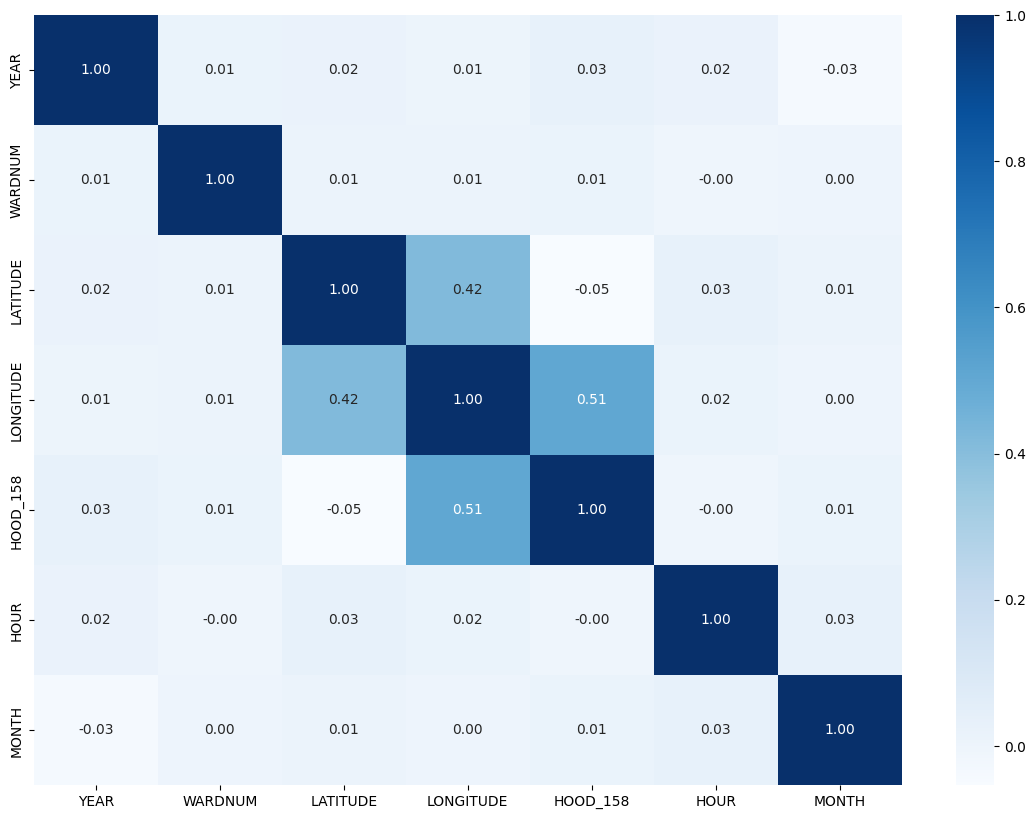

In [33]:
# co-relation between numerical variables
plt.figure(figsize=(14, 10))
sns.heatmap(df[numerical_cols].corr(), annot=True, fmt=".2f", cmap='Blues')
plt.show()

In [34]:
import re

def sanitize_feature_names(feature_names):
    # Remove or replace invalid characters in feature names
    sanitized_names = [re.sub(r'[,\[\]<>]', '', name).replace(' ', '_') for name in feature_names]
    return sanitized_names



### Dataset preparation

- One-hot encode nominal features
- Label encoder for oridnal
- Train test split

In [35]:
scaler = MinMaxScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False), nominal_features),  
        ('ordinal', OrdinalEncoder(), ordinal_features),  
        ('scale', scaler, numerical_cols) 
    ], remainder='passthrough'
)

data_preprocessed = preprocessor.fit_transform(df)

new_columns = (preprocessor.named_transformers_['onehot'].get_feature_names_out(nominal_features).tolist() +
               ordinal_features +
               numerical_cols)

data_encoded = pd.DataFrame(data_preprocessed, columns=new_columns)


sanitized_feature_names = sanitize_feature_names(data_encoded.columns)


data_encoded.columns = sanitized_feature_names

y = df['ACCLASS'].values  

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


X = data_encoded.drop('ACCLASS', axis=1)  


X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.1, stratify=y_encoded, random_state=42)


for column in X_train.columns:
    if X_train[column].dtype == 'object':
        X_train[column] = X_train[column].astype(int)
        X_test[column] = X_test[column].astype(int)

/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



# Modeling

In [36]:
from catboost import CatBoostClassifier

lr_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['liblinear', 'saga']
}
rfc_params = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30, 40, 50],
}
svc_params = {
    'C': [0.1],
    'kernel': ['linear', 'rbf']
}
xgb_parameters = {'n_estimators': [10, 50, 100, 200], 
                  'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3]
}

catboost_params = {
    'iterations': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 10]
}


# Create model instances
models_params = {
    'XGBoost': (XGBClassifier(enable_categorical=True),xgb_parameters),
    'LogisticRegression': (LogisticRegression(max_iter=1000), lr_params),
    'RandomForestClassifier': (RandomForestClassifier(), rfc_params),
    'CatBoost' : (CatBoostClassifier(verbose=0), catboost_params)

}


best_models = {}
best_scores = {}

for model_name, (model, params) in models_params.items():
    clf = GridSearchCV(model, params, cv=5, scoring='accuracy', n_jobs=-1)
    clf.fit(X_train, y_train)
    best_models[model_name] = clf.best_estimator_
    best_scores[model_name] = clf.best_score_
    print(f"{model_name} best score: {clf.best_score_}")



print("="*10,"Testing Accuracies: ","="*10)
# Evaluate the best models on the test set
test_scores = {}
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    test_scores[model_name] = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {test_scores[model_name]}")

XGBoost best score: 0.9553333333333333


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression best score: 0.952962962962963


RandomForestClassifier best score: 0.9473333333333332


/usr/local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



CatBoost best score: 0.9497037037037037
========== Testing Accuracies:  ==========


XGBoost Accuracy: 0.9553333333333334
LogisticRegression Accuracy: 0.962
RandomForestClassifier Accuracy: 0.9526666666666667


CatBoost Accuracy: 0.9506666666666667


In [37]:
from sklearn.ensemble import StackingClassifier


stacking_ensemble = StackingClassifier(
    estimators=[
        ('CatBoost', best_models['CatBoost']),
        ('RandomForestClassifier', best_models['RandomForestClassifier']),
        # ('XGBoost', best_models['XGBoost']),
        ('LogisticRegression', best_models['LogisticRegression']),


    ],
    final_estimator=LogisticRegression(),
    cv=5,
    # n_jobs=-1
)

# Fit the stacking 
stacking_ensemble.fit(X_train, y_train)

# Predictions and evaluation on the test set
y_pred_ensemble = stacking_ensemble.predict(X_test)
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)

print(f"Stacking Ensemble Model Accuracy: {ensemble_accuracy}")


Stacking Ensemble Model Accuracy: 0.984


In [38]:
from typing import Any
class ClassificationReport:

    def __init__(self, model,model_name, X_test, y_test) -> None:
        self.model = model
        self.X_test = X_test
        self.y_test = y_test
        self.model_name = model_name

    
    def draw_cm(self,cm):

        fig, ax = plt.subplots(figsize=(8, 8))

        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=["Not Survived", "Survived"], yticklabels=["Not Survived", "Survived"])
        ax.set_title(f'Confusion Matrix - {self.model_name}')
        ax.set_xlabel('Predicted labels')
        ax.set_ylabel('True labels')

        return fig
        

    def draw_roc_auc(self, fpr, tpr, auc_score):
        fig, ax = plt.subplots(figsize=(8, 8))

        ax.plot(fpr, tpr, label=f'{self.model_name} (AUC = {auc_score:.2f})')
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'ROC Curve - {self.model_name}')
        ax.legend(loc='lower right')

        return fig

    def __call__(self) -> Any:  
     
        
        # make predictions using model 
        y_pred = self.model.predict(self.X_test)

        print("="*10,self.model_name,"="*10)

        print(f"Classification Report:\n")

        print(classification_report(self.y_test, y_pred))

        cm = confusion_matrix(self.y_test, y_pred)

        cm_figure = self.draw_cm(cm)

     
        y_prob = self.model.predict_proba(self.X_test)[:, 1]
        fpr, tpr, _ = roc_curve(self.y_test, y_prob)
        auc_score = roc_auc_score(self.y_test, y_prob)
        roc_fig = self.draw_roc_auc(fpr,tpr,auc_score)
            


        cm_figure.show()
        roc_fig.show()

========== XGBoost ==========
Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.71      0.81       202
           1       0.96      0.99      0.97      1298

    accuracy                           0.96      1500
   macro avg       0.95      0.85      0.89      1500
weighted avg       0.95      0.96      0.95      1500



========== LogisticRegression ==========
Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.84      0.86       202
           1       0.97      0.98      0.98      1298

    accuracy                           0.96      1500
   macro avg       0.93      0.91      0.92      1500
weighted avg       0.96      0.96      0.96      1500



========== RandomForestClassifier ==========
Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.65      0.79       202
           1       0.95      1.00      0.97      1298

    accuracy                           0.95      1500
   macro avg       0.97      0.83      0.88      1500
weighted avg       0.95      0.95      0.95      1500

========== CatBoost ==========
Classification Report:



              precision    recall  f1-score   support

           0       1.00      0.63      0.78       202
           1       0.95      1.00      0.97      1298

    accuracy                           0.95      1500
   macro avg       0.97      0.82      0.87      1500
weighted avg       0.95      0.95      0.95      1500



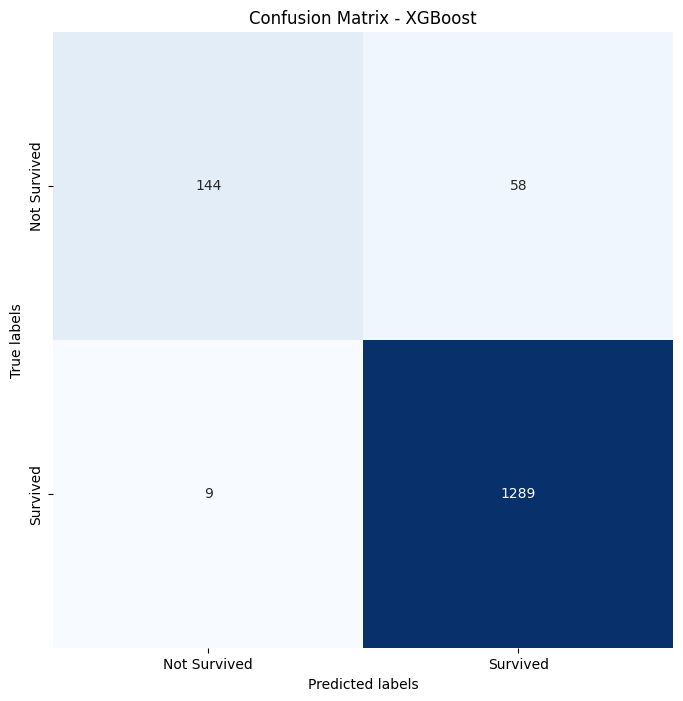

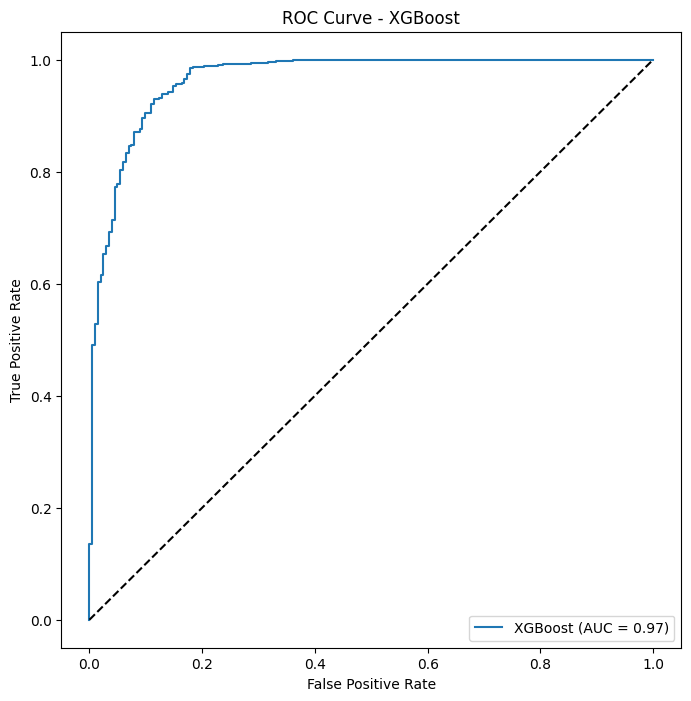

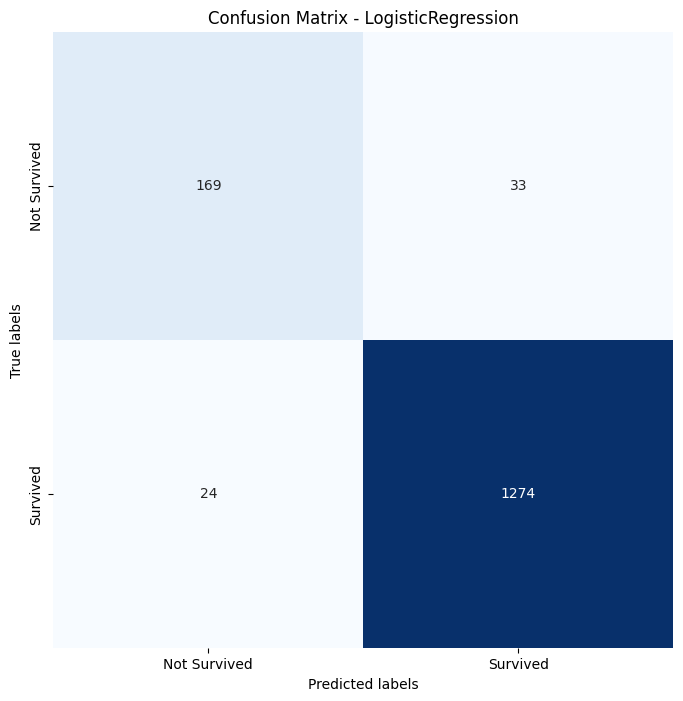

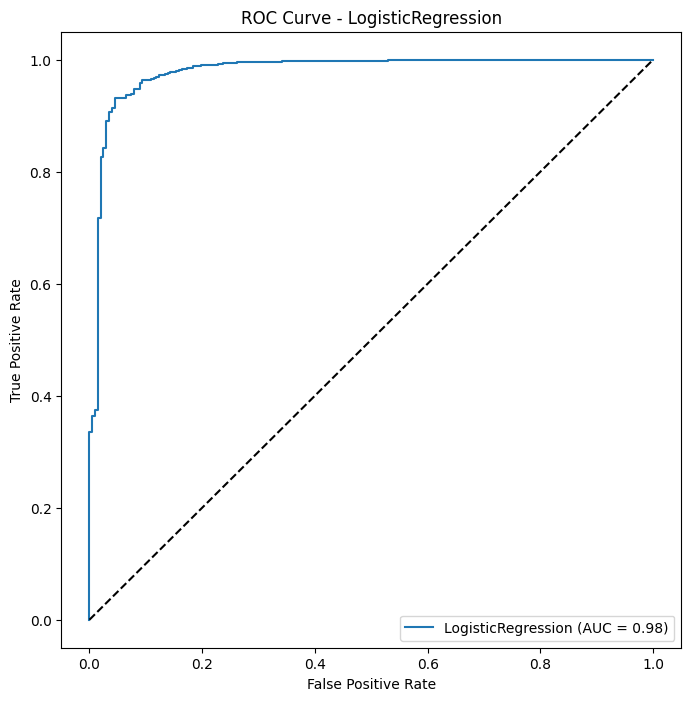

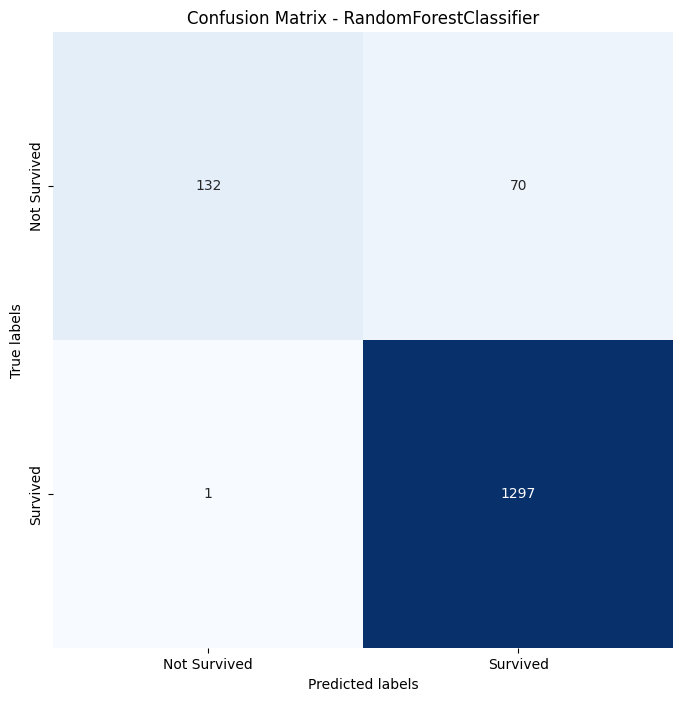

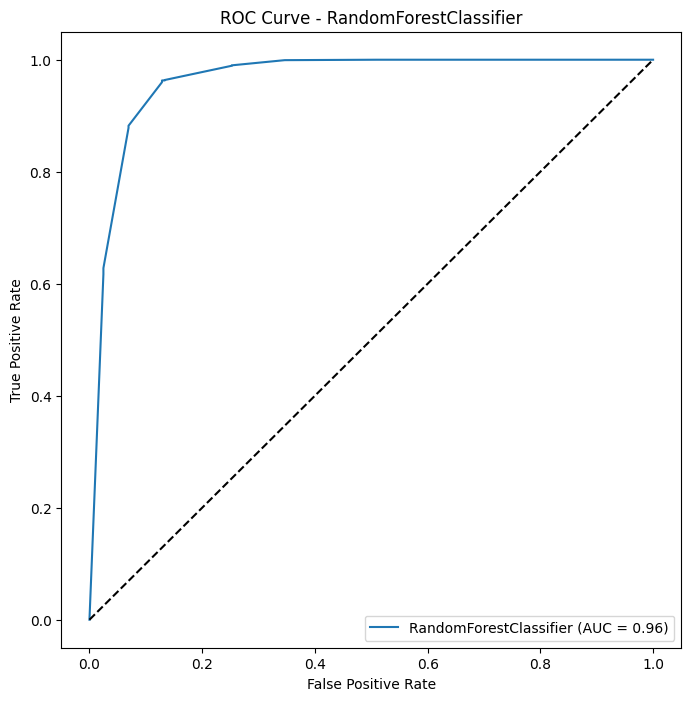

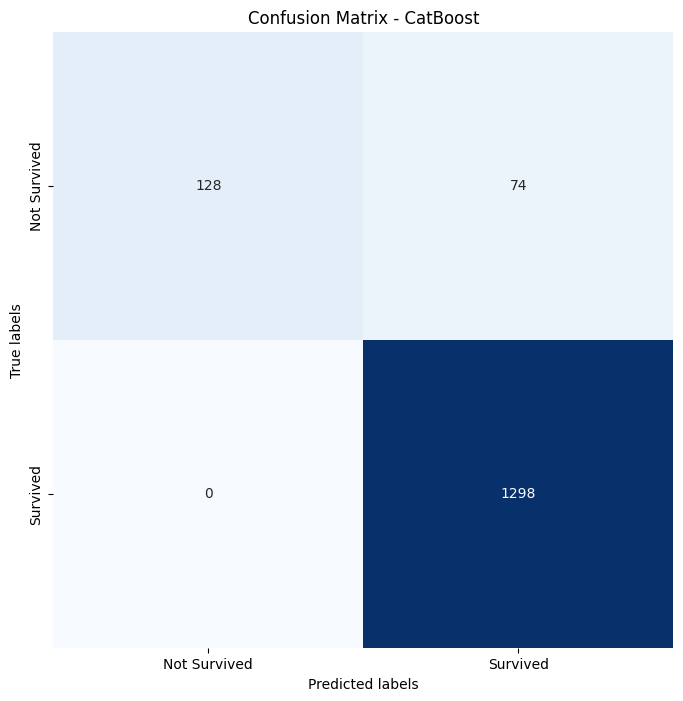

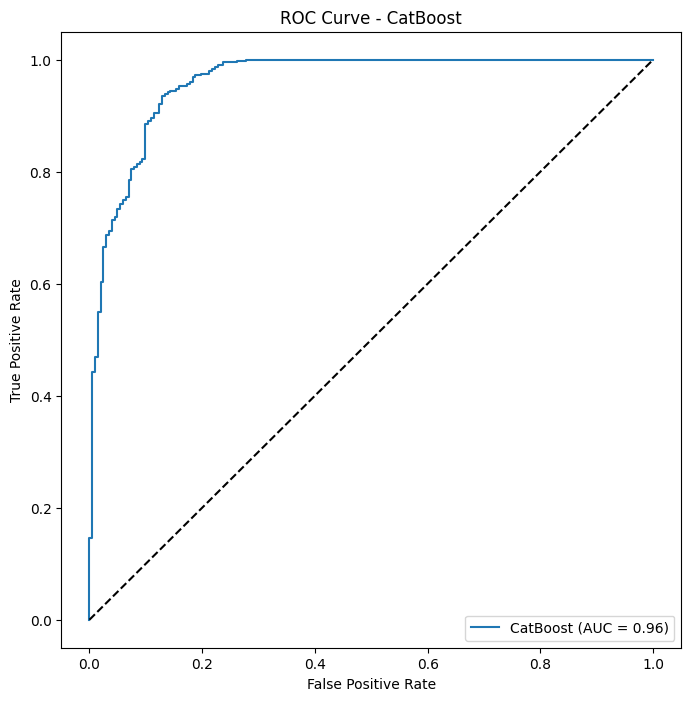

In [39]:
for model_name, model in best_models.items():
    ClassificationReport(model=model,model_name=model_name, X_test=X_test, y_test=y_test)()

========== Stacked Models ==========
Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       202
           1       0.99      0.99      0.99      1298

    accuracy                           0.98      1500
   macro avg       0.98      0.96      0.96      1500
weighted avg       0.98      0.98      0.98      1500



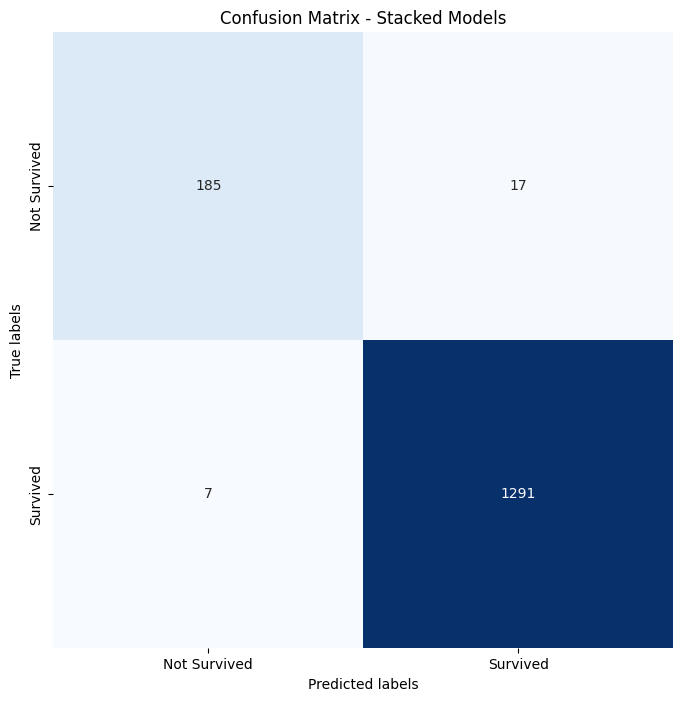

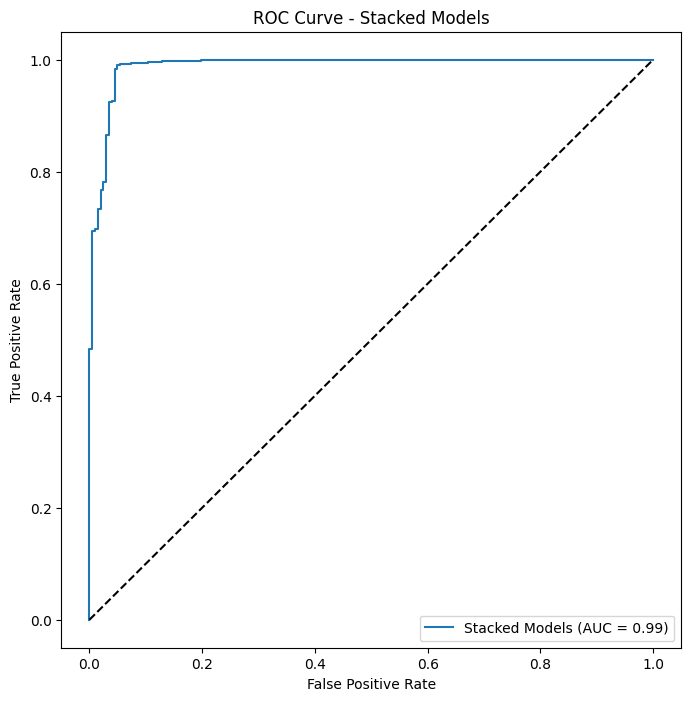

In [40]:
ClassificationReport(model=stacking_ensemble,model_name="Stacked Models", X_test=X_test, y_test=y_test)()


**Analyzing the feature importance**

In [41]:
feature_names = X_train.columns

# Feature importance for each algorithm 
for model_name, model in best_models.items():

    if model_name in ["RandomForestClassifier", "XGBoost"]:
        print(f"="*10,model_name,"10 important features.",f"="*10)
        importances = pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending=False)
        print(importances.head(20))

    elif model_name == "CatBoost":
        print(f"="*10,model_name,"10 important features.",f"="*10)
        importances = pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending=False)
        print(importances.head(20))

========== XGBoost 10 important features. ==========
INJURY                                                         0.141820
INTERSECTION_SCARBOROUGH_GOLF_CLUB_RD_/_BRIMORTON_DR           0.055941
INTERSECTION_LAWRENCE_AVE_E_/_E_OF_DVP_ON_RAMP_Aven            0.023812
PEDESTRIAN_No                                                  0.018764
INTERSECTION_KIPLING_AVE_/_WESTHUMBER_BLVD                     0.018259
DIVISION_D23                                                   0.018203
INTERSECTION_LAKE_SHORE_BLVD_E_/_DON_ROADWAY                   0.014222
IMPACTYPE_Rear_End                                             0.012679
TRUCK_No                                                       0.012597
INTERSECTION_EGLINTON_AVE_E_/_CREDIT_UNION_DR                  0.012243
INVTYPE_Other                                                  0.012114
INTERSECTION_DANFORTH_AVE_/_COXWELL_AVE                        0.011799
INTERSECTION_MIDLAND_AVE_/_ELLESMERE_RD                        0.011736
DISABILITY_

## Neural Network

In [42]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

In [43]:
# converting data to pytorch 
X_train_torch = torch.tensor(X_train.values).float()
y_train_torch = torch.tensor(y_train).float()
X_test_torch = torch.tensor(X_test.values).float()
y_test_torch = torch.tensor(y_test).float()


# creating datalodaers
train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [44]:
class CustomClassifier(nn.Module):

    def __init__(self, input_features ) -> None:
        super().__init__()
        self.input_features = input_features

        self.linear_1 = nn.Linear(in_features=self.input_features,out_features=64)
        self.linear_2 = nn.Linear(in_features=64,out_features=32)
        self.linear_3 = nn.Linear(in_features=32,out_features=1)

        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()


    def forward(self,x):

        x = self.linear_1(x)
        x = self.relu(x)
        x = self.linear_2(x)
        x = self.relu(x)
        x = self.linear_3(x)
        return self.sig(x)
    

model = CustomClassifier(input_features=X_train.shape[1])

    
# define loss and optimizer
# loss
loss_fn = nn.BCELoss()
# optimizer
optimizer = torch.optim.Adam(model.parameters())


/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [45]:
# Initialize lists to track losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # Calculate accuracy
        predicted = outputs.squeeze().round()  
        correct += (predicted == targets).sum().item()
        total += targets.size(0)
    
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # Evaluate validation loss and accuracy
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            val_loss += loss_fn(outputs.squeeze(), targets).item()

            predicted = outputs.squeeze().round()
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

    val_losses.append(val_loss / len(test_loader))
    val_accuracies.append(correct / total)

    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}, Train Accuracy: {train_accuracies[-1]}, Validation Accuracy: {val_accuracies[-1]}")


Epoch 1, Train Loss: 0.37806168421043607, Validation Loss: 0.3318147022039332, Train Accuracy: 0.8580740740740741, Validation Accuracy: 0.868


Epoch 2, Train Loss: 0.2886775042243761, Validation Loss: 0.23148471338951843, Train Accuracy: 0.8816296296296297, Validation Accuracy: 0.9053333333333333


Epoch 3, Train Loss: 0.15260589863416427, Validation Loss: 0.15851685198697638, Train Accuracy: 0.9404444444444444, Validation Accuracy: 0.934


Epoch 4, Train Loss: 0.0931136230331232, Validation Loss: 0.11118191837313328, Train Accuracy: 0.9625925925925926, Validation Accuracy: 0.9506666666666667


Epoch 5, Train Loss: 0.0693310219824857, Validation Loss: 0.08688846420734486, Train Accuracy: 0.9728888888888889, Validation Accuracy: 0.964


Epoch 6, Train Loss: 0.058467129200710184, Validation Loss: 0.20541137836853715, Train Accuracy: 0.9755555555555555, Validation Accuracy: 0.93


Epoch 7, Train Loss: 0.049115484242738, Validation Loss: 0.0842162679008981, Train Accuracy: 0.98, Validation Accuracy: 0.9653333333333334


Epoch 8, Train Loss: 0.0364290197168574, Validation Loss: 0.07293170781191835, Train Accuracy: 0.9854074074074074, Validation Accuracy: 0.972


Epoch 9, Train Loss: 0.03002524346942733, Validation Loss: 0.07352276630030866, Train Accuracy: 0.9883703703703703, Validation Accuracy: 0.974


Epoch 10, Train Loss: 0.02434545920823008, Validation Loss: 0.07002711460301454, Train Accuracy: 0.9903703703703703, Validation Accuracy: 0.9773333333333334


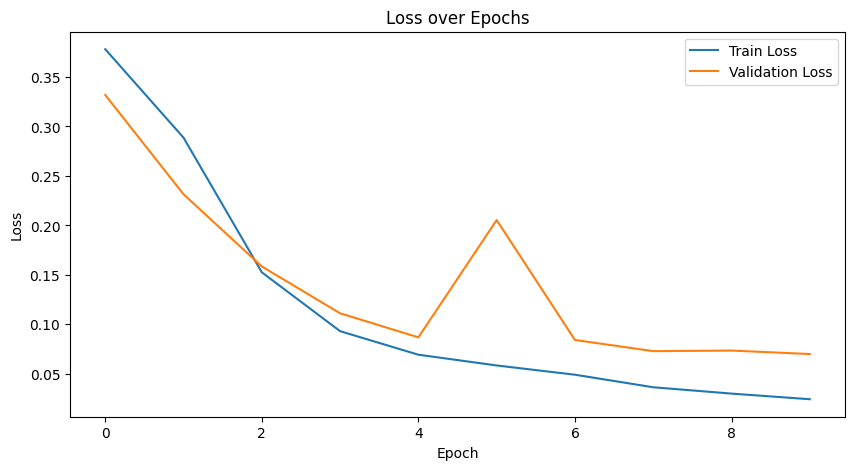

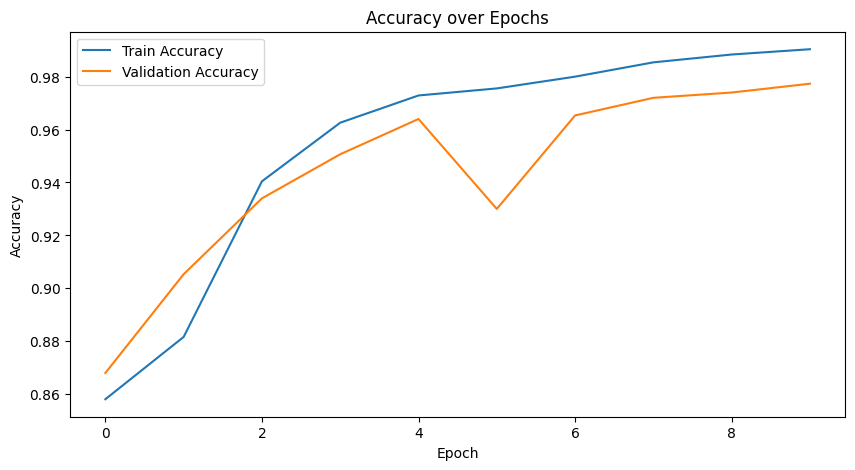

In [46]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

# Plotting train and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

              precision    recall  f1-score   support

           0       0.94      0.89      0.91       202
           1       0.98      0.99      0.99      1298

    accuracy                           0.98      1500
   macro avg       0.96      0.94      0.95      1500
weighted avg       0.98      0.98      0.98      1500



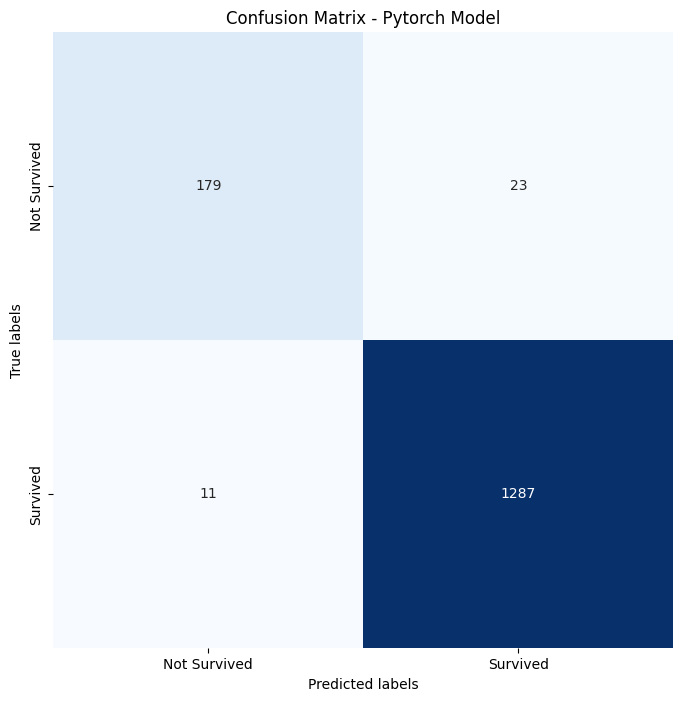

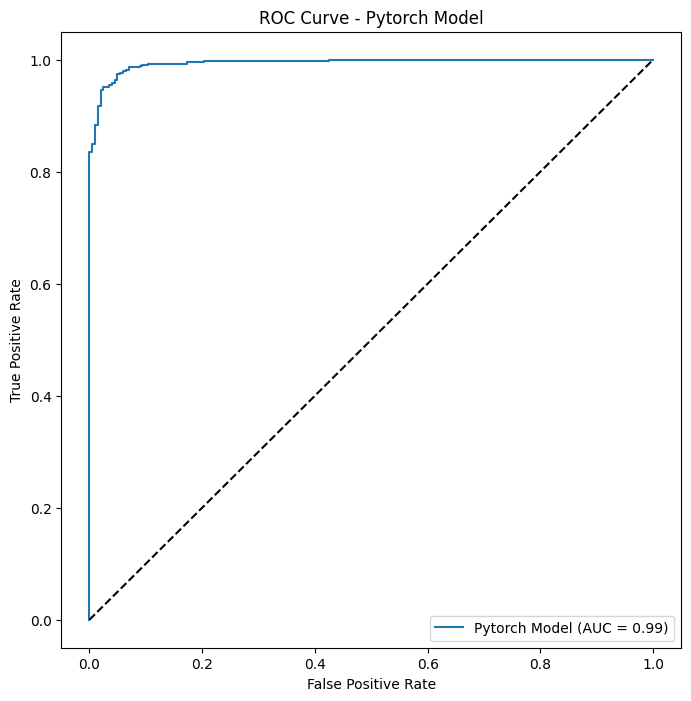

In [47]:
from typing import Any
from sklearn.metrics import auc

class ClassificationReport:

    def __init__(self, model,model_name, test_loader, y_test) -> None:
        self.model = model
        self.model_name = model_name
        self.test_loader = test_loader
        self.y_test = y_test

    
    def draw_cm(self,cm):

        fig, ax = plt.subplots(figsize=(8, 8))

        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=["Not Survived", "Survived"], yticklabels=["Not Survived", "Survived"])
        ax.set_title(f'Confusion Matrix - {self.model_name}')
        ax.set_xlabel('Predicted labels')
        ax.set_ylabel('True labels')

        return fig
        

    def draw_roc_auc(self, fpr, tpr, auc_score):
        fig, ax = plt.subplots(figsize=(8, 8))

        ax.plot(fpr, tpr, label=f'{self.model_name} (AUC = {auc_score:.2f})')
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'ROC Curve - {self.model_name}')
        ax.legend(loc='lower right')

        return fig

    def __call__(self) -> Any:  
     
        
        self.model.eval()
        y_pred_prob = []
        with torch.no_grad():
            for inputs, _ in self.test_loader:
                outputs = self.model(inputs).squeeze().numpy()
                y_pred_prob.extend(outputs)
        y_pred_class = np.round(y_pred_prob)

        # Confusion Matrix
        cm = confusion_matrix(self.y_test, y_pred_class)
        print(classification_report(self.y_test, y_pred_class))


        cm_figure = self.draw_cm(cm)


        fpr, tpr, thresholds = roc_curve(self.y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        roc_fig = self.draw_roc_auc(fpr,tpr,roc_auc)   
     
        cm_figure.show()
        roc_fig.show()


ClassificationReport(model=model,model_name="Pytorch Model", test_loader=test_loader, y_test=y_test)()




## For Kaggle Submission

In [48]:
# read the test dataframe 
test_df = pd.read_csv("/kaggle/input/is-the-traffic-collision-fatal/Test.csv")

filtered_object_ids = test_df['ObjectId']


MAR_ = ['PEDESTRIAN', 'CYCLIST', 'MOTORCYCLE', 'TRUCK', 'TRSN_CITY_VEH', 'EMERG_VEH', 'PASSENGER', 'SPEEDING', 'REDLIGHT', 'ALCOHOL', 'DISABILITY', "AUTOMOBILE", "AG_DRIV"]
test_df[MAR_] = test_df[MAR_].fillna("No")

test_df['INTERSECTION'] = test_df.apply(create_intersection, axis=1)

# We can drop the street 1 and 2 features now 
test_df.drop(['STREET1', 'STREET2'], axis=1, inplace=True)


In [49]:
# Convert TIME into Hour and drop Hour 
test_df['HOUR'] = test_df['TIME'].astype(str).str.zfill(4).str[:2].astype(int)

# Ensure 'DATE' is in datetime format
test_df['DATE'] = pd.to_datetime(test_df['DATE'])
test_df['YEAR'] = test_df['DATE'].dt.year
test_df['MONTH'] = test_df['DATE'].dt.month
test_df.drop("TIME", axis= 1 , inplace= True)

# get all the columns from the train dataframe that we decided as to be a feature.
main_df_columns = df.columns.to_list()
main_df_columns.remove("ACCLASS")

# set test df based on train_df_columns
test_df = test_df[main_df_columns]

In [50]:

# check if the difference is just ACLASS
set(list(df.columns)) - set(list(test_df.columns))

{'ACCLASS'}

In [51]:

# filling the missing values before inference
col_mis_val = test_df.columns[test_df.isnull().sum() > 0].to_list()

for col in col_mis_val:
    mode_value = test_df[col].mode()[0]
    print(f"Mode of column : {col} is : {mode_value} ")
    test_df[col] = test_df[col].fillna(mode_value)


test_df.loc[test_df['HOOD_158'] == 'NSA', 'HOOD_158'] = 0

test_df["HOOD_158"] = pd.to_numeric(test_df["HOOD_158"])


Mode of column : ROAD_CLASS is : Major Arterial 
Mode of column : DISTRICT is : Toronto and East York 
Mode of column : WARDNUM is : 10.0 
Mode of column : LOCCOORD is : Intersection 
Mode of column : TRAFFCTL is : No Control 
Mode of column : VISIBILITY is : Clear 
Mode of column : RDSFCOND is : Dry 
Mode of column : IMPACTYPE is : Pedestrian Collisions 
Mode of column : INVTYPE is : Driver 
Mode of column : INJURY is : None 
Mode of column : INITDIR is : West 
Mode of column : VEHTYPE is : Automobile, Station Wagon 
Mode of column : MANOEUVER is : Going Ahead 


In [52]:

ordinal_features_test = ordinal_features
ordinal_features_test.remove("ACCLASS")

data_preprocessed_test = preprocessor.fit_transform(test_df)

new_columns = (preprocessor.named_transformers_['onehot'].get_feature_names_out(nominal_features).tolist() +
               ordinal_features +
               numerical_cols)

data_encoded_test = pd.DataFrame(data_preprocessed_test, columns=new_columns)

sanitized_feature_names = sanitize_feature_names(data_encoded_test.columns)


data_encoded_test.columns = sanitized_feature_names


# Apply label encoding to ordainal features

for feature in ordinal_features_test:
    data_encoded_test[feature] = label_encoder.fit_transform(test_df[feature])


/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



In [53]:
for column in data_encoded_test.columns:
    if data_encoded_test[column].dtype == 'object':
        data_encoded_test[column] = data_encoded_test[column].astype(int)


In [54]:
from copy import deepcopy
missing_cols = set(data_encoded.columns) - set(data_encoded_test.columns)
missing_cols.discard("ACCLASS")  
missing_cols_df = pd.DataFrame(0, index=data_encoded_test.index, columns=missing_cols)
data_encoded_test = pd.concat([data_encoded_test, missing_cols_df], axis=1)
train_f_c = list(deepcopy(data_encoded.columns))
train_f_c.remove("ACCLASS")
test_data_encoded = data_encoded_test[train_f_c]


In [55]:
predictions = stacking_ensemble.predict(test_data_encoded)

In [56]:
assert len(predictions) == len(filtered_object_ids), "Length of predictions must match the number of ObjectIds after filtering."

predictions_text = np.where(predictions == 1, "Non-Fatal Injury", "Fatal")

submission_df = pd.DataFrame({
    "ObjectId": filtered_object_ids,
    "ACCLASS": predictions_text
})

submission_df.reset_index(drop=True, inplace=True)

submission_df.to_csv("submission.csv", index=False)

In [57]:

predictions = best_models["CatBoost"].predict(test_data_encoded)


assert len(predictions) == len(filtered_object_ids), "Length of predictions must match the number of ObjectIds after filtering."

predictions_text = np.where(predictions == 1, "Non-Fatal Injury", "Fatal")

submission_df = pd.DataFrame({
    "ObjectId": filtered_object_ids,
    "ACCLASS": predictions_text
})

submission_df.reset_index(drop=True, inplace=True)

submission_df.to_csv("submission_cat.csv", index=False)

In [58]:
predictions = best_models["XGBoost"].predict(test_data_encoded)


assert len(predictions) == len(filtered_object_ids), "Length of predictions must match the number of ObjectIds after filtering."


predictions_text = np.where(predictions == 1, "Non-Fatal Injury", "Fatal")

submission_df = pd.DataFrame({
    "ObjectId": filtered_object_ids,
    "ACCLASS": predictions_text
})

submission_df.reset_index(drop=True, inplace=True)

submission_df.to_csv("submission_xg.csv", index=False)

In [59]:
predictions = best_models["RandomForestClassifier"].predict(test_data_encoded)


assert len(predictions) == len(filtered_object_ids), "Length of predictions must match the number of ObjectIds after filtering."

predictions_text = np.where(predictions == 1, "Non-Fatal Injury", "Fatal")

submission_df = pd.DataFrame({
    "ObjectId": filtered_object_ids,
    "ACCLASS": predictions_text
})

submission_df.reset_index(drop=True, inplace=True)

submission_df.to_csv("submission_rf.csv", index=False)

In [60]:

test_data_torch = torch.tensor(test_data_encoded.values).float()

model.eval()
with torch.no_grad():
    logits = model(test_data_torch)

predictions_binary = logits.squeeze().round().numpy()
predictions_text = np.where(predictions_binary == 1, "Non-Fatal Injury", "Fatal")
assert len(predictions_text) == len(filtered_object_ids), "Length of predictions must match the number of ObjectIds."
submission_df = pd.DataFrame({
    "ObjectId": filtered_object_ids,
    "ACCLASS": predictions_text
})
submission_df.reset_index(drop=True, inplace=True)
submission_df.to_csv("pytorch_submission.csv", index=False)
